In [1]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

from mpl_toolkits.mplot3d import Axes3D

import cv2

import shutil
from tqdm import tqdm
import albumentations as A

2024-01-03 10:58:15.191559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 10:58:15.191597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 10:58:15.222908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 10:58:15.287996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 10:58:16.045203: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2024-01-03 10:58:17.460928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 10:58:17.665330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 10:58:17.665362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
print(tf.__version__)

2.15.0


In [4]:
import torch
print(torch.version.cuda)

12.1


In [5]:
"""
placeholder_ex = tf.placeholder(tf.int32, shape=(1, 2, 3))
print(placeholder_ex)
placeholder_sum_ex = tf.add(placeholder_ex, placeholder_ex)
print(placeholder_sum_ex)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
"""

'\nplaceholder_ex = tf.placeholder(tf.int32, shape=(1, 2, 3))\nprint(placeholder_ex)\nplaceholder_sum_ex = tf.add(placeholder_ex, placeholder_ex)\nprint(placeholder_sum_ex)\nsess = tf.Session()\nsess.run(tf.global_variables_initializer())\n'

In [6]:
root = "../ham/"
train_df = pd.read_csv(root + "working/train_df.csv")
valid_df = pd.read_csv(root + "working/valid_df.csv")
test_df = pd.read_csv(root + "working/test_df.csv")

train_df["labels"] = train_df['labels'].apply(lambda x: str(x))
valid_df["labels"] = valid_df['labels'].apply(lambda x: str(x))
test_df["labels"] = test_df['labels'].apply(lambda x: str(x))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     3648 non-null   object 
 1   image_id      3648 non-null   object 
 2   dx            3648 non-null   object 
 3   dx_type       3648 non-null   object 
 4   age           3636 non-null   float64
 5   sex           3648 non-null   object 
 6   localization  3648 non-null   object 
 7   filepaths     49000 non-null  object 
 8   cell_type     3648 non-null   object 
 9   labels        49000 non-null  object 
 10  ita           3648 non-null   float64
 11  ita labels    3648 non-null   float64
dtypes: float64(3), object(9)
memory usage: 4.5+ MB


In [8]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,ita labels
0,HAM_0003877,ISIC_0031537,bkl,histo,60.0,female,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0031537...,Benign keratosis-like lesions,2,93.551707,1.0
1,HAM_0000581,ISIC_0034115,bkl,histo,40.0,female,chest,d:/ham/ham/HAM10000_images_part_2/ISIC_0034115...,Benign keratosis-like lesions,2,72.649742,1.0
2,HAM_0000114,ISIC_0029674,bkl,histo,65.0,male,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0029674...,Benign keratosis-like lesions,2,121.354330,1.0
3,HAM_0000344,ISIC_0032972,bkl,histo,55.0,male,trunk,d:/ham/ham/HAM10000_images_part_2/ISIC_0032972...,Benign keratosis-like lesions,2,108.230116,1.0
4,HAM_0003281,ISIC_0031903,bkl,histo,70.0,male,upper extremity,d:/ham/ham/HAM10000_images_part_2/ISIC_0031903...,Benign keratosis-like lesions,2,82.855513,1.0


In [9]:
train_df["filepaths"] = train_df["filepaths"].str.replace("d:", "..")
train_df["filepaths"] = train_df["filepaths"].str.replace("\\", "/")
valid_df["filepaths"] = valid_df["filepaths"].str.replace("d:", "..")
valid_df["filepaths"] = valid_df["filepaths"].str.replace("\\", "/")
test_df["filepaths"] = test_df["filepaths"].str.replace("d:", "..")
test_df["filepaths"] = test_df["filepaths"].str.replace("\\", "/")

In [10]:
"""
cnt = 0
for f in train_df["filepaths"]:
    if os.path.exists(f) == False:
        print(f)
        cnt = cnt + 1
"""

'\ncnt = 0\nfor f in train_df["filepaths"]:\n    if os.path.exists(f) == False:\n        print(f)\n        cnt = cnt + 1\n'

In [11]:
"""
cnt = 0
for f in train_df["filepaths"]:
    if cnt < 10:
        with Image.open(f) as img:
            aaa = img.size
        print(aaa)
    cnt = cnt + 1
"""

'\ncnt = 0\nfor f in train_df["filepaths"]:\n    if cnt < 10:\n        with Image.open(f) as img:\n            aaa = img.size\n        print(aaa)\n    cnt = cnt + 1\n'

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=8
img_size = (600,450)
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 49000 validated image filenames belonging to 7 classes.          for train generator 
Found 1001 validated image filenames belonging to 7 classes.           for valid generator 
Found 1002 validated image filenames belonging to 7 classes.           for test generator 
test batch size:  6   test steps:  167  number of classes :  7


In [13]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [15]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax

def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
       
    base_model.trainable= True

    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    # Evidential Begins
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

class_count=7
lr=.001
model=make_model(img_size, lr) # using B3 model by default

2024-01-03 11:00:00.322702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 11:00:00.322750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 11:00:00.322767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 11:00:00.599203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-03 11:00:00.599243: I external/local_xla/xla/stream_executor

Created EfficientNet B3 model with initial learning rate set to 0.001



In [16]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor

    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground

        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      

        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [17]:
epochs = 40
ask_epoch = 2
ask=LR_ASK(model, epochs,  ask_epoch)

In [18]:
from tensorflow.keras import backend as K

history=model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/40


2024-01-03 11:00:12.260293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-03 11:00:13.666243: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 11:00:14.033972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-03 11:00:14.199101: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 11:00:15.512947: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb7ce511fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 11:00:15.512986: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 40

6125/6125 [==============================] - 1716s 276ms/step - loss: 2.1030 - accuracy: 0.7975 - F1_score: 0.7774 - auc: 0.9680 - val_loss: 0.7783 - val_accuracy: 0.8292 - val_F1_score: 0.8147 - val_auc: 0.9717
Epoch 2/40
6125/6125 [==============================] - 1663s 272ms/step - loss: 0.3712 - accuracy: 0.9527 - F1_score: 0.9478 - auc: 0.9968 - val_loss: 0.8149 - val_accuracy: 0.8152 - val_F1_score: 0.8149 - val_auc: 0.9594
Epoch 3/40
6125/6125 [==============================] - 1671s 273ms/step - loss: 0.2253 - accuracy: 0.9803 - F1_score: 0.9782 - auc: 0.9991 - val_loss: 0.7446 - val_accuracy: 0.8511 - val_F1_score: 0.8478 - val_auc: 0.9624
Epoch 4/40
6125/6125 [==============================] - 1671s 273ms/step - loss: 0.1668 - accuracy: 0.9889 - F1_score: 0.9872 - auc: 0.9995 - val_loss: 0.7191 - val_accuracy: 0.8282 - val_F1_score: 0.8290 - val_auc: 0.9654
Epoch 5/40
6125/6125 [==============================] - 1669s 273ms/step - loss: 0.1399 - accuracy: 0.9914 - F1_score: 

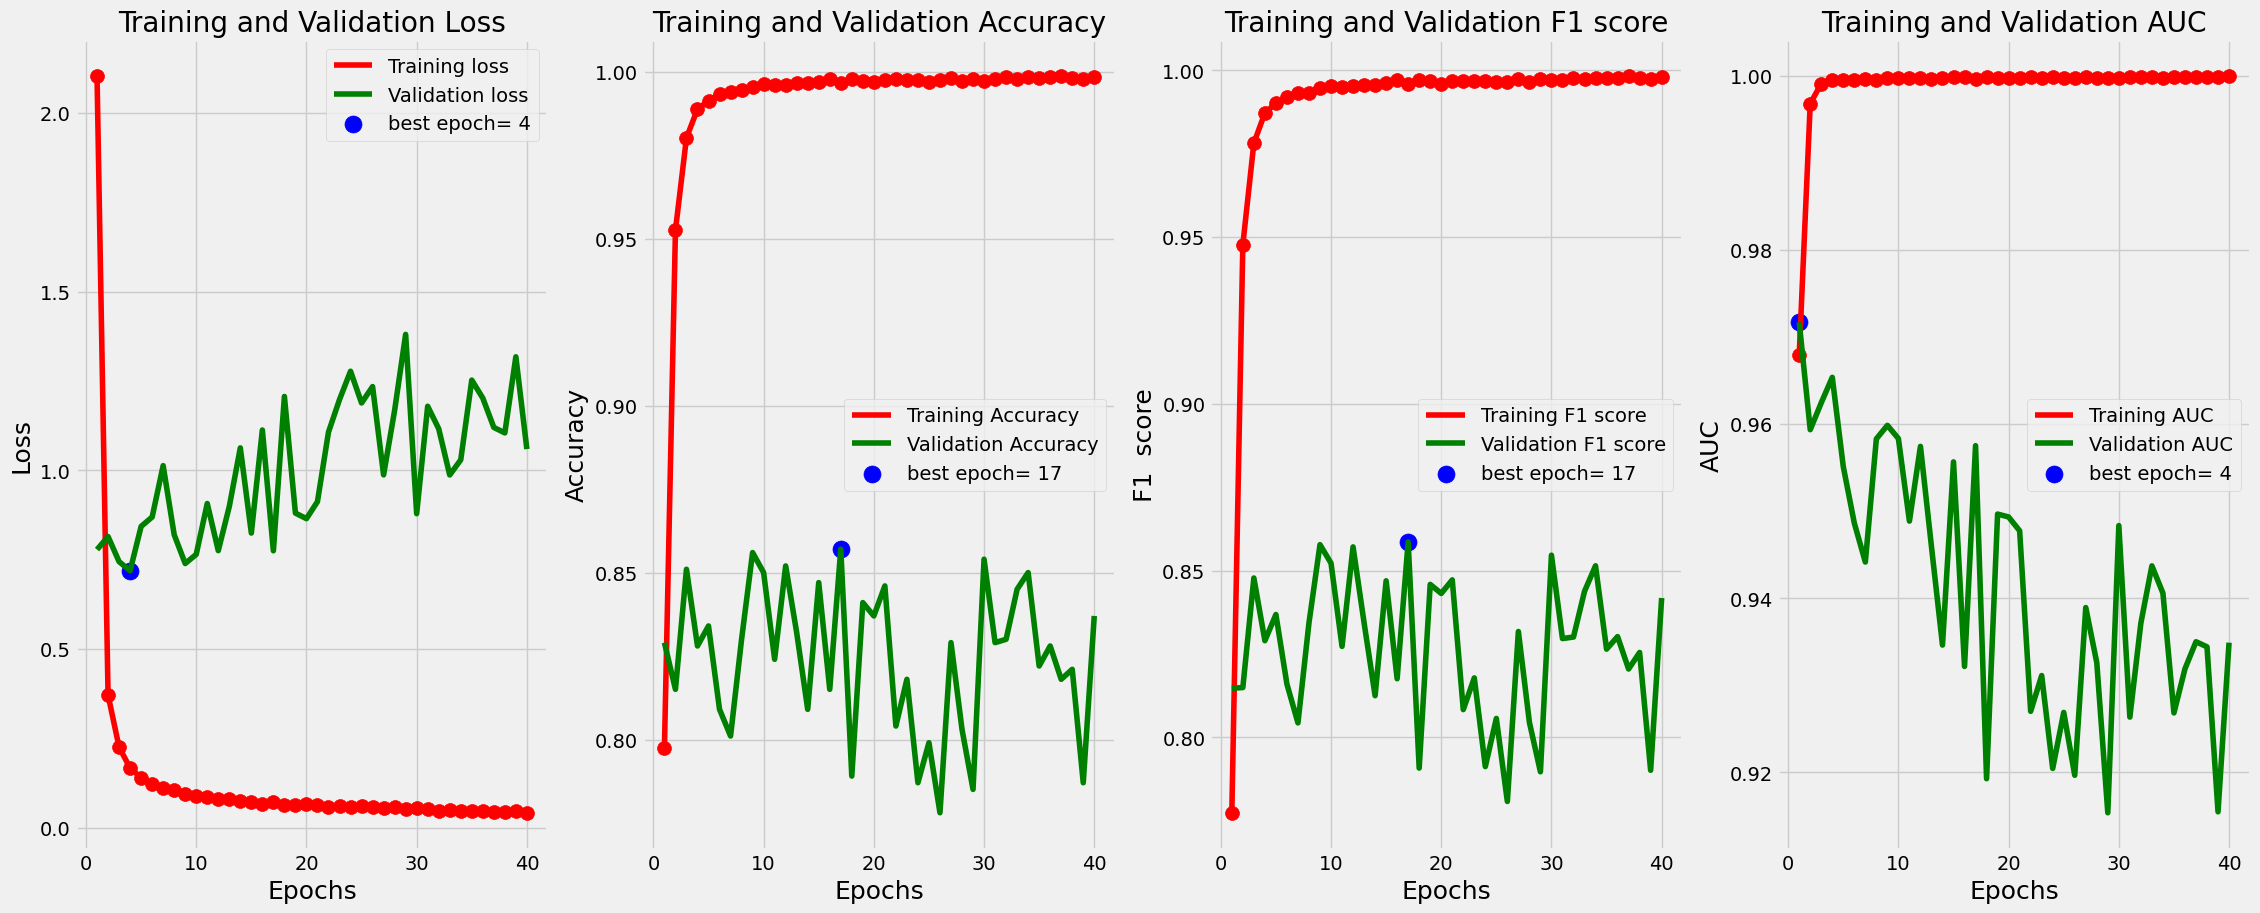

In [19]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

In [20]:
model.save(root + "working/saved_model2/")

INFO:tensorflow:Assets written to: ../ham/working/saved_model2/assets


INFO:tensorflow:Assets written to: ../ham/working/saved_model2/assets


In [23]:
#Test

# model load
model_path = root + "working/saved_model2/"
model2 = tf.keras.models.load_model(model_path, custom_objects={'F1_score': F1_score})

# Needs to compile again as for lr setting
lr=.001
model2.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 450, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 600, 450, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 600, 450, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 600, 450, 3)          0         ['normalization[0][0]']   

In [24]:
# To check
model2.layers[-1].get_weights()[0]

array([[ 0.00235935, -0.18162821, -0.12592748, ..., -0.13496386,
        -0.15794499, -0.18303472],
       [-0.96251297,  1.6716968 , -0.84361833, ..., -1.3162552 ,
        -1.90994   , -1.6251901 ],
       [-1.0693579 , -1.1946516 , -1.0779537 , ...,  1.829945  ,
        -1.7358441 , -1.4520962 ],
       ...,
       [-1.3265548 , -1.4702365 , -1.4958813 , ..., -1.5700049 ,
        -1.6845931 ,  2.169589  ],
       [-1.0516658 , -0.88379276,  1.7660949 , ..., -1.2377522 ,
        -1.5635567 , -1.5252115 ],
       [-0.9903722 ,  1.5742825 , -0.7556226 , ..., -0.97610706,
        -1.4696906 , -1.7495589 ]], dtype=float32)